# Analyze Region 5 - Greenland Periphery

This notebook analyzes the largest glaciers, ice caps, and ice fields in Region 5 - Greenland Periphery.

This region was deemed as needing a glacier complex analysis (ice caps and icefields), so note that the abbreviation "ic" stands for ice catchment aka glacier complex.

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "5"
region_name = "Greenland Periphery"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 4 # This is a guess from looking at literature (Luckman, 2003; Weidick, 1995)

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 4
region_index_2 = 5

# Ice cap/icefield epsg code used for calculating area
ic_epsg = '3178' #'32627'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

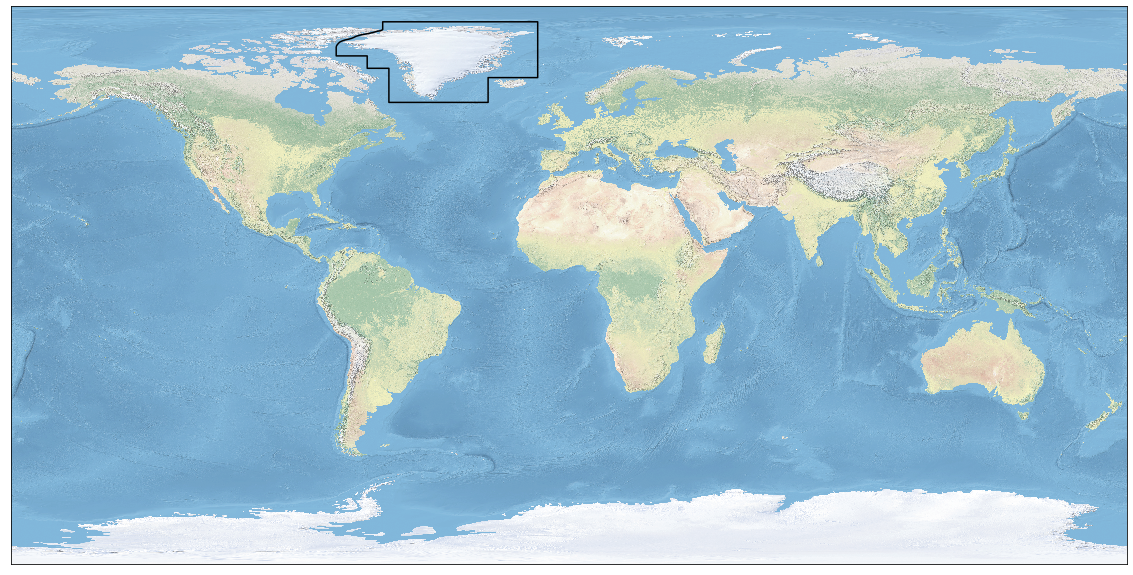

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

minx  miny  maxx  maxy
4 -75.0  59.0 -10.0  85.0

# * * * * * * * * Glacier Analysis * * * * * * * *

For Greenland, need to filter the glaciers by those that have connectivity level 0 or 1. If they are level 2, it means they are too connected to the ice sheet and don't fit our definition of glacier in this project. Only RGI contains this connectivity metadata. So filtered RGI for glaciers with 0 or 1 connectivity and now cross referencing them to GLIMS.

1. RGI ID: RGI60-05.10749, GLIMS ID: G322065E82674N
2. RGI ID: RGI60-05.00459, GLIMS ID: G309162E65933N
3. RGI ID: RGI60-05.13995, GLIMS ID: G323748E66257N

## Open RGI 3 Largest Glaciers Data

In [7]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [8]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

RGI glacier 0 equals none
RGI glacier 1 equals none
RGI glacier 2 equals none
RGI glacier 3 equals none
RGI glacier 4 equals none


In [9]:
rgi_glaciers_df

RGIId         GLIMSId   BgnDate   EndDate   CenLon   CenLat  \
0  RGI60-05.10315  G344790E81287N  20010703  -9999999 -15.2101  81.2869   
1  RGI60-05.10749  G322065E82674N  19999999  20049999 -37.9353  82.6735   
2  RGI60-05.00459  G309162E65933N  20000823  -9999999 -50.8380  65.9328   
3  RGI60-05.13995  G323748E66257N  20000909  -9999999 -36.2521  66.2572   
4  RGI60-05.00460  G308629E65949N  20000823  -9999999 -51.3711  65.9493   

  O1Region O2Region      Area  Zmin  ...  Aspect   Lmax  Status  Connect  \
0        5        1  7537.579    32  ...      63   3890       0        0   
1        5        1   738.938    32  ...     300  40508       0        0   
2        5        1   600.409    91  ...     168  48018       0        1   
3        5        1   582.810    60  ...     215  50953       0        1   
4        5        1   573.547    36  ...     220  35910       0        1   

   Form  TermType  Surging  Linkages  Name  \
0     0         1        9         9  NONE   
1     1         1        9         9  NONE   
2     1         0        9         9  NONE   
3     0         1        9         9  NONE   
4     0         1        9         9  NONE   

                                            geometry  
0  POLYGON ((-14.16361495199993 81.29903210400005...  
1  POLYGON ((-38.37329431199998 82.88780234700005...  
2  POLYGON ((-51.00189210799994 66.05496811200004...  
3  POLYGON ((-36.20135722999993 66.40701665400007...  
4  POLYGON ((-51.25995569099996 66.08669195300007...  

[5 rows x 23 columns]

## Open GLIMS 3 Largest Glaciers Data

This section is different from other regions because I need to use the glacier IDs I filtered from RGI for this. This section is also usually before the Open RGI data section, however, since I need the GLIMS IDs out of the RGI data, swapping these two secctions around.

In [10]:
# Open GLIMS region 5 cleaned data file and search for the apprpriate glaciers by ID filtered from RGI
glims_glaciers_fn = "data/glims/processed/cleaned/glims_region_5_cleaned.shp"
glims_glaciers_all_df = gpd.read_file(glims_glaciers_fn)

In [11]:
# Find the GLIMS records from the GLIMS IDS in the RGI dataframe
glims_ids = [rgi_glaciers_df['GLIMSId'][1], rgi_glaciers_df['GLIMSId'][2], rgi_glaciers_df['GLIMSId'][3]]
for counter, x in enumerate(glims_ids):
    print(x)
    if counter == 0:
        # Set up first instance of dataframe so we can append to it later
        glims_glaciers_df = glims_glaciers_all_df[glims_glaciers_all_df['glac_id']==x]
    else:
        glims_glaciers_df_part = glims_glaciers_all_df[glims_glaciers_all_df['glac_id']==x]
        glims_glaciers_df = glims_glaciers_df.append(glims_glaciers_df_part)
    
glims_glaciers_df = glims_glaciers_df.reset_index(drop=True)

G322065E82674N
G309162E65933N
G323748E66257N


In [12]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [13]:
glims_glaciers_df

region_no         glac_id     area  db_area  width  length  primeclass  \
0          5  G322065E82674N  738.938  739.068    0.0     0.0         0.0   
1          5  G309162E65933N  600.409  607.232    0.0     0.0         0.0   
2          5  G323748E66257N  582.810  583.373    0.0     0.0         0.0   

   min_elev  mean_elev  max_elev             src_date glac_name  \
0      32.0        0.0    1483.0  1999-09-01T00:00:00      None   
1      91.0        0.0    1780.0  2000-08-23T00:00:00      None   
2      60.0        0.0    1843.0  2000-09-09T00:00:00      None   

                                            geometry  
0  POLYGON Z ((-38.373294 82.88780199999999 0, -3...  
1  POLYGON Z ((-51.025265 66.02346199999999 0, -5...  
2  POLYGON Z ((-36.201357 66.407017 0, -36.201526...

## Plot GLIMS Glaciers

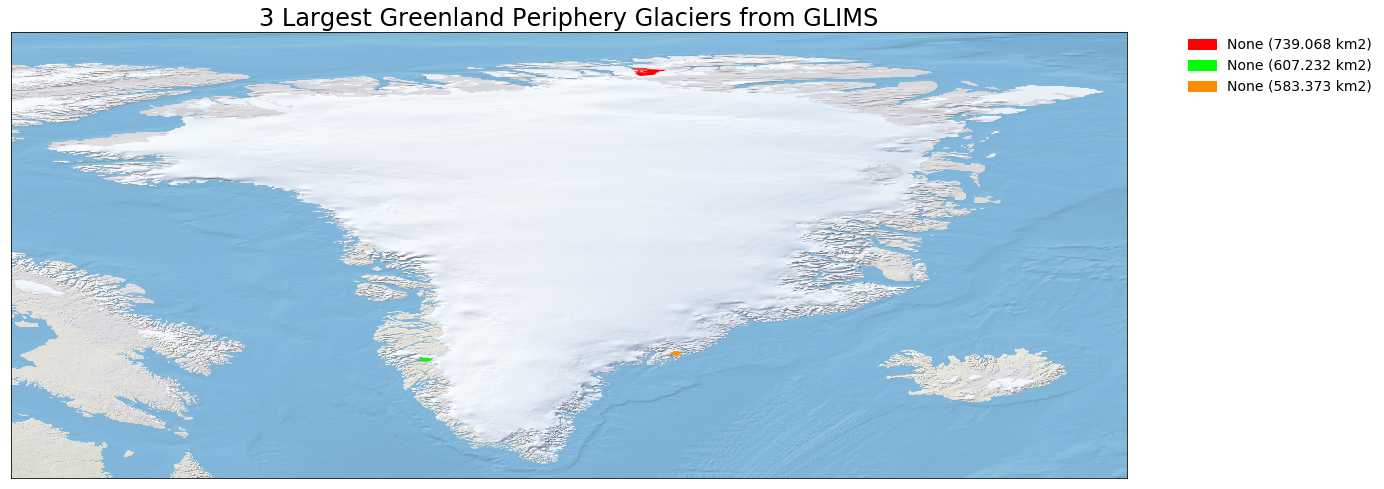

In [14]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Plot RGI Glaciers

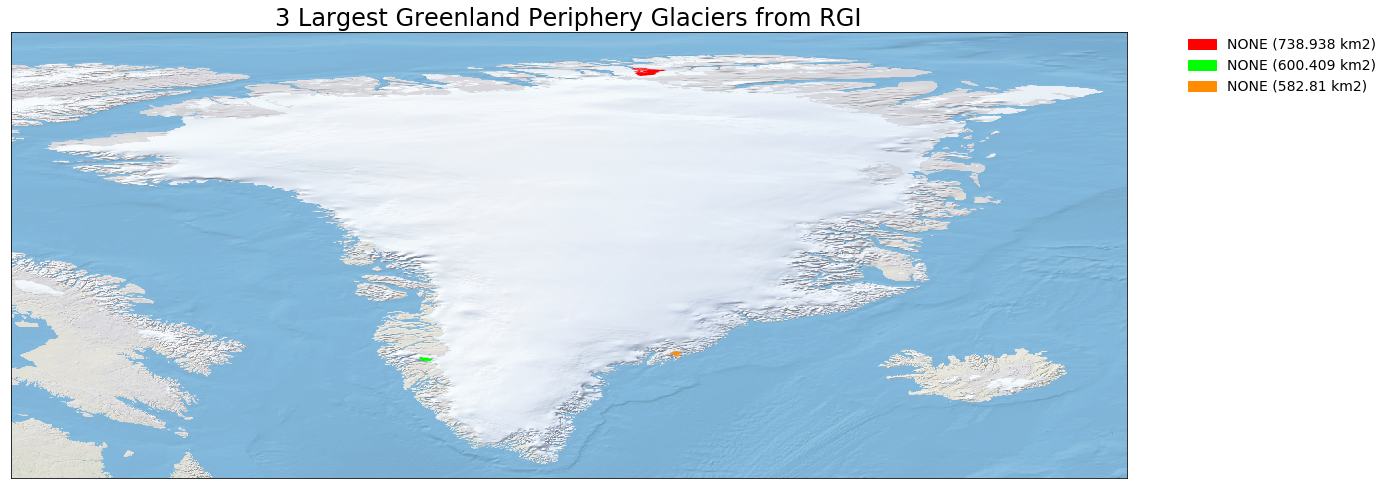

In [15]:
# Plot 3 largest glaciers on natural earth from RGI
# NOTE: Skipping 1st entry because it is an ice cap
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)',
                 rgi_glaciers_df['Name'][3] + ' (' + str(rgi_glaciers_df['Area'][3]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[3:4].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate. Once the differences have been investigated and corrected in the code below this code block, set handled to 1 in the "Set Up Region Info" section at the top of the notebook, so that it passes this test.

For glaiciers with connectivity 0 or 1, here are the names that I've found:
1. largest (G322065E82674N) No real name that I can find. Perhaps call it Central Dome Glacier? (Zekollari, 2017). Andreas Peter said he thinks this is Tjalfe Glacier per Bjørk et al. (2015)
1. 2nd largest (G309162E65933N) Can't find a name. It's near the Amitsuloq ice cap and Taseriaq lake. Will just call it "Unnamed Glacier"
1. 3rd largest (G323748E66257N) From a photo in Google Earth, this is labeld as Knud Rasmussen Galcier

The notes below pertain to glaciers with connectivity level 2. As of 9/10/20, we have decided that only glaciers with connectivity level 0 or 1 will be considered. Thus, these notes are no longer pertinent. 
The largest in both GLIMS and RGI is an ice cap - Flade Islblink. Will need to skip this in the glacier section and use it in the ice cap section lower down.

The name of the 3rd largest in RGI is Magga Dan.

Deciding on the 3 largest to be Christian IV, Vestfjord, and Dendrit.

In [16]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create Final Glacier Shapefiles
This section creates and formats the final glacier dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

### Create final glacier dataframe

In [17]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_glacier_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                                'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_glacier_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_glacier_data_df['primeclass'] = primeclass

# Rename some columns
final_glacier_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop 1 st rows because its an ice cap and 5th row because we aren't interested in it
#final_glacier_data_df.drop([0, 4], inplace = True)

# Add RGI ID column
final_glacier_data_df['rgi_id'] = (rgi_glaciers_df['RGIId'][1], rgi_glaciers_df['RGIId'][2], 
                                   rgi_glaciers_df['RGIId'][3])

# Add area_src column that gets filled lower down
final_glacier_data_df['area_src'] = '-999'

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                               'primeclass', 'area_km2', 'area_src', 'date', 'geometry']]

In [18]:
final_glacier_data_df

region_no             reg_name glac_name        glims_id          rgi_id  \
0          5  Greenland Periphery      None  G322065E82674N  RGI60-05.10749   
1          5  Greenland Periphery      None  G309162E65933N  RGI60-05.00459   
2          5  Greenland Periphery      None  G323748E66257N  RGI60-05.13995   

   primeclass  area_km2 area_src                 date  \
0           4   739.068     -999  1999-09-01T00:00:00   
1           4   607.232     -999  2000-08-23T00:00:00   
2           4   583.373     -999  2000-09-09T00:00:00   

                                            geometry  
0  POLYGON Z ((-38.373294 82.88780199999999 0, -3...  
1  POLYGON Z ((-51.025265 66.02346199999999 0, -5...  
2  POLYGON Z ((-36.201357 66.407017 0, -36.201526...

In [19]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
# For Region 5, RGI doesn't contain the two largest glaciers, so use the GLIMS size for them. For the 3rd largest,
# do an average since their dates are the same

# Average the area of the 3rd largest which is 4th largest in GLIMS and 2nd largest in RGI
# and set the area in the final dataframe
#area = np.average([glims_glaciers_df['db_area'][3], rgi_glaciers_df['Area'][1]])
#final_glacier_data_df.iloc[2, final_glacier_data_df.columns.get_loc('area_km2')] = area

for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x+1] # adding 1 because need to skip the first row
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    if glims_year == rgi_year:
        # Average GLIMS and RGI areas
        area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x+1]])
        area_src = 'A'
        print('Averaging area: ' + str(area))
    elif glims_year > rgi_year:
        # Use GLIMS area for the area
        area = glims_glaciers_df['db_area'][x]
        area_src = 'G'
        print('Using GLIMS area: ' + str(area))
    elif rgi_year > glims_year:
        # Use RGI area for the area
        area = rgi_glaciers_df['Area'][x+1]
        area_src = 'R'
        print('Using RGI area: ' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_src')] = area_src
    
    # Clean the date format in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = \
    glims_glaciers_df['src_date'][x][0:10]
    
    # Clean the date format in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = \
    glims_glaciers_df['src_date'][x][0:10]
    
    # Clean up glacier names, use GLIMS for 1st and 2nd largest and RGI for 3rd
    if x == 0:
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = \
        'Tjalfe Glacier'
    if x == 1:
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = \
        'Unnamed Glacier'
    if x == 2:
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = 'Knud Rasmussen Glacier'
        
# Reset index
final_glacier_data_df = final_glacier_data_df.reset_index(drop=True)

glims date: 19990901
rgi date: 19999999
Averaging area: 739.0029999999999

glims date: 20000823
rgi date: 20000823
Averaging area: 603.8205

glims date: 20000909
rgi date: 20000909
Averaging area: 583.0915



In [20]:
final_glacier_data_df

region_no             reg_name               glac_name        glims_id  \
0          5  Greenland Periphery          Tjalfe Glacier  G322065E82674N   
1          5  Greenland Periphery         Unnamed Glacier  G309162E65933N   
2          5  Greenland Periphery  Knud Rasmussen Glacier  G323748E66257N   

           rgi_id  primeclass  area_km2 area_src        date  \
0  RGI60-05.10749           4  739.0030        A  1999-09-01   
1  RGI60-05.00459           4  603.8205        A  2000-08-23   
2  RGI60-05.13995           4  583.0915        A  2000-09-09   

                                            geometry  
0  POLYGON Z ((-38.373294 82.88780199999999 0, -3...  
1  POLYGON Z ((-51.025265 66.02346199999999 0, -5...  
2  POLYGON Z ((-36.201357 66.407017 0, -36.201526...

### Plot final glacier dataframe to check accuracy

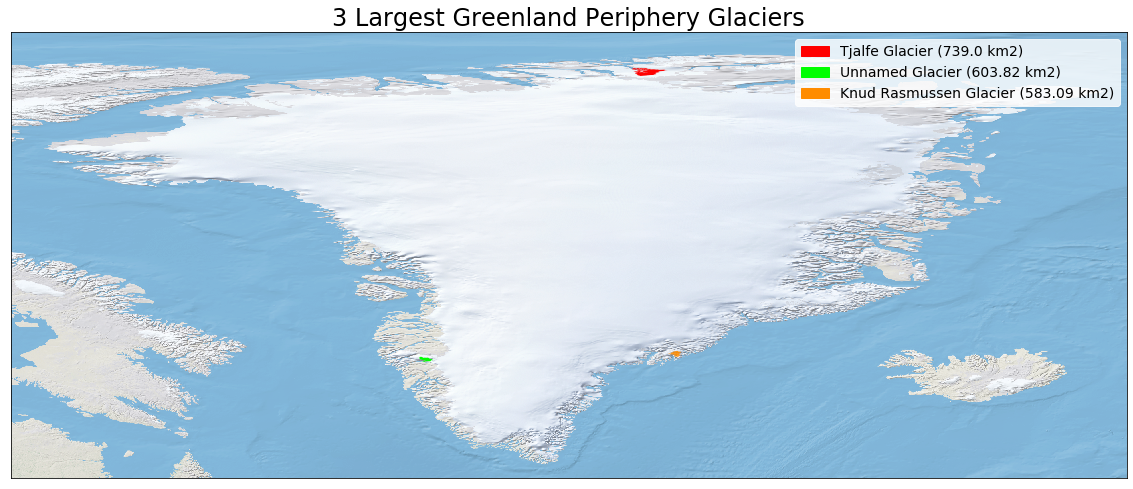

In [21]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_glacier_data_df['glac_name'][0] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][0], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][1] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][1], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][2] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_glacier_data_df.iloc[0:1].plot(ax=ax, color='red')
final_glacier_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_glacier_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create largest glacier shapefile from the final glacier dataframe

In [22]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
glacier_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(glacier_zipfile_fn) == False:
    # Create the shapefile
    final_glacier_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_glacier_data_df.to_file(driver='ESRI Shapefile', filename=final_glacier_data_fn)
    
    # Zip up the shapefile
    glacier_zipfile_fn = ws.zipshp(final_glacier_data_fn, Delete=True)
    print("Creating zipfile: " + glacier_zipfile_fn)
else:
    print(glacier_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-5-largest-glaciers.zip


# * * * * * * * * Ice Cap Analysis * * * * * * * *

In [ ]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                  region_number + "_epsg" + ic_epsg + ".shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [ ]:
ice_caps_ex_df

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = ['Geikie Plateau (296)', 'Flade Isblink (11869)', 'Hans Tausen ice cap (11805)', 
                 'Stauning Alps (12146)', 'Hutchinson Plateau (6719)', 'Unknown (4962)', 'The North Ice Cap (10909)', 
                 'Renland Area (181)', 'Amitsulôq Ice Cap (4966)', 'Sukkertoppen Ice Cap (4963)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [ ]:
# Stop notebook and examine ice caps and icefields. 
# Comment this out when not needed.
#class StopExecution(Exception):
#    def _render_traceback_(self):
#        pass

#print("Stopping notebook to examine glacier complexes.")
#raise StopExecution

## Create Final Ice Catchment Data Frame
This ice catchment data frame will then be saved to a shapefile.

Going to go with Flade Isblink as the largest ice cap followed by Hans Tausen. Note Hans Tausen is the northern most ice cap in the world. 

The Stauning Alps do not appear to be covered in an ice cap and neither are the Geikie Plateau or Hutchinson Plateau(according to Satellite Image Atlas of Glaciers of the World - Greenland (Weidick, 1995), these are "areas"), so I think the next biggest one is the North Ice Cap. 

Will use the Flade Isblink polygon from the GLIMS database (ID G344790E81287N). Bolch et al (2013) give a size of ~7,500 km^2 and I have it at 7,538 km^2. Will need to clip the Hans Tausen ice cap since it picked up some extra ice during the "explode" operation. It looks like it contains Bure Ice Cap as well (Landvik et al 2001) but that ref gives the size at 4,200 km^2 and the size if have hear is 4,117 km^2. I think the North Ice Cap looks good based on Greenland Plate 1 (Weidick, 1995).

### Clip Bure Ice Cap away from Hans Tausen Ice Cap

In [ ]:
# Create a clipping polygon for Hans Tausen Ice Cap
# Create dataframe that holds the clipping box
hans_area_points = Polygon([(-42.7752, 82.7661), (-39.8419, 83.0774),
                            (-35.6232, 82.8827), (-35.9088, 82.6475), 
                            (-36.4581, 82.5570), (-36.3675, 82.4686),
                            (-35.8209, 82.3901), (-39.4464, 81.9671),
                            (-42.7752, 82.7661)])

hans_gdf = gpd.GeoDataFrame([1],
                            geometry=[hans_area_points],
                            crs={'init': 'epsg:' + ic_epsg})

hans_ex_ic_index = ice_caps_ex_df[ice_caps_ex_df['id']==11805].index.values
hans_ex_ic_df = cl.clip_shp(ice_caps_ex_df.iloc[hans_ex_ic_index[0]:hans_ex_ic_index[0]+1], hans_gdf)
hans_ex_ic_df.reset_index(drop=True, inplace=True)

In [ ]:
hans_ex_ic_df

In [ ]:
# Determine area of this clipped Hans Tausen ice cap
hans_ex_area = hans_ex_ic_df['geometry'].to_crs({'init': 'epsg:' + ic_epsg}).area/10**6
round(hans_ex_area[0], 6)

In [ ]:
# Plot the new Hans Tausen Ice Cap to see if it is correct
# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
hans_ex_ic_df.plot(ax=ax, color="darkorange")
ax.set_title('Hans Tausen Ice Caps', fontsize=24)
ax.set_axis_off()

plt.show()

In [ ]:
# Write dataframe to shapefile and save to zip so I can review it in ArcMap
hans_zipfile_fn = "data/glims/processed/ice-caps/exploded/region-" + region_number + "-hans-tausen-clip.zip"
if os.path.exists(hans_zipfile_fn) == False:
    # Create the shapefile
    hans_data_fn = "data/glims/processed/ice-caps/exploded/region-" + region_number + "-hans-tausen-clip.shp"
    hans_ex_ic_df.to_file(driver='ESRI Shapefile', filename=hans_data_fn)
    
    # Zip up the shapefile
    hans_zipfile_fn = ws.zipshp(hans_data_fn, Delete=True)
    print("Creating zipfile: " + hans_zipfile_fn)
else:
    print(hans_zipfile_fn + " already extists")

In [ ]:
# Open the GLIMS largest glaciers which contains Flade Isblink
# Have to do this since now only interested in glacier with connectivity 0 or 1 in the glacier analysis
# However, when this file was created, wasn't filtering for that, so Flade Isblink is part of this shapefile
glims_glaciers_lg_fn = "data/glims/processed/largest/glims_region_5_largest.shp"
glims_glaciers_lg_df = gpd.read_file(glims_glaciers_lg_fn)

In [ ]:
glims_glaciers_lg_df

### Set up Ice Cap data frame

In [ ]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop uneeded rows: first 6 and last 3 rows because only keeping North Ice cap
final_catchment_data_df.drop([0, 1, 2, 3, 4, 5, 7, 8, 9], inplace = True)

# Add Flade Isblink from the glacier dataframe
final_catchment_data_df = final_catchment_data_df.append(glims_glaciers_lg_df.iloc[0:1].drop(['region_no',
                                                                                           'glac_id', 
                                                                                           'db_area', 
                                                                                           'width',
                                                                                           'length',
                                                                                           'primeclass',
                                                                                           'min_elev',
                                                                                           'max_elev',
                                                                                           'mean_elev',
                                                                                           'src_date',
                                                                                           'glac_name'], axis=1))

# Add Hans Tausen dataframe and update its area measurement
final_catchment_data_df = final_catchment_data_df.append(hans_ex_ic_df.drop(['id'], axis=1))
final_catchment_data_df.iloc[2, final_catchment_data_df.columns.get_loc('area')] = round(hans_ex_area[0], 6)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [3, 3, 3]

# Sort the dataframe by largest to smallest ice cap
final_catchment_data_df = final_catchment_data_df.sort_values(by = "area", ascending = False)

# Add catchment names
final_catchment_data_df['ic_name'] = ['Flade Isblink', 'Hans Tausen Ice Cap', 'North Ice Cap']

### Get ice catchment measurement dates from a range of glacier outline dates.

Note that for Flade Isblink we can just take the single date straight from the GLIMS database because it is aready the true outline of that ice cap.

In [ ]:
# Open GLIMS shapefile with all of the glacier outlines
glims_all_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_all_glaciers_fn)

In [ ]:
# Set the min and max date for Flade Isblink from the GLIMS largest database value
flade_glaciers_min_date = glims_glaciers_lg_df.iloc[0:1]['src_date'][0][0:10]
flade_glaciers_max_date = glims_glaciers_lg_df.iloc[0:1]['src_date'][0][0:10]
print('flade start date: ' + flade_glaciers_min_date)
print('flade end date: ' + flade_glaciers_max_date)
print('')

# Get glaciers on Hans Tausen Ice Cap
hans_ic_mask = ws.pip(glims_all_glaciers_df, hans_ex_ic_df.reset_index(drop=True))
hans_glaciers = glims_all_glaciers_df.loc[hans_ic_mask]

# Print the minimum date and the maximum date
hans_glaciers_min_date = hans_glaciers['src_date'].min()[0:10]
hans_glaciers_max_date = hans_glaciers['src_date'].max()[0:10]
print('hans start date: ' + hans_glaciers_min_date)
print('hans end date: ' + hans_glaciers_max_date)
print('')

# Get glaciers on North Ice Cap
north_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[6:7].reset_index(drop=True))
north_glaciers = glims_all_glaciers_df.loc[north_ic_mask]

# Print the minimum date and the maximum date
north_glaciers_min_date = north_glaciers['src_date'].min()[0:10]
north_glaciers_max_date = north_glaciers['src_date'].max()[0:10]
print('north start date: ' + north_glaciers_min_date)
print('north end date: ' + north_glaciers_max_date)
print('')

In [ ]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [flade_glaciers_min_date, hans_glaciers_min_date, north_glaciers_min_date]

final_catchment_data_df['max_date'] = [flade_glaciers_max_date, hans_glaciers_max_date, north_glaciers_max_date]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 'min_date', 
                                                   'max_date', 'geometry']]
# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [ ]:
final_catchment_data_df

### Plot the final catchment dataframe to verify it looks correct

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="darkorange")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="red")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="blue")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [ ]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")